# Training — Digits classification with PyTorch (MLP)

## Goal:
Train a simple neural network to classify digits (0–9) from `sklearn.datasets.load_digits()`.

We will:
1. Load the dataset
2. Split into train/test sets (stratified)
3. Normalize pixel values (between 0 , 1)
4. Convert data to PyTorch tensors
5. Create DataLoaders (mini-batches)
6. Define a simple MLP model
7. Train the model with a training loop
8. Evaluate accuracy on the test set
9. Plot training curves (loss over epochs)

## Required libraries

Let's start by importing the libraries we need for:
- data handling
- model training

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Set a random seed for reproducibility and select the available device (CUDA / MPS / CPU).

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device:", device)


Device: cpu


## Step 1 — Load, split, normalize

We load the dataset and perform a stratified train/test split.

Then we normalize pixel values:
- raw pixels are in [0, 16]
- we rescale to [0, 1] by dividing by 16.0

Normalization helps training stability.

In [10]:
digits = load_digits()
X = digits.data.astype(np.float32)   # (n_samples, 64)
y = digits.target.astype(np.int64)   # (n_samples,)

# Stratified split keeps class proportions similar in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Before normalization:")
print("X_train min/max:", X_train.min(), X_train.max())
print("X_test  min/max:", X_test.min(), X_test.max())

# Normalize to [0,1]
X_train = X_train / 16.0
X_test = X_test / 16.0

print("\nAfter normalization:")
print("X_train min/max:", X_train.min(), X_train.max())
print("X_test  min/max:", X_test.min(), X_test.max())

Before normalization:
X_train min/max: 0.0 16.0
X_test  min/max: 0.0 16.0

After normalization:
X_train min/max: 0.0 1.0
X_test  min/max: 0.0 1.0


## Step 2 — Convert to PyTorch tensors and create DataLoaders

PyTorch models work with `torch.Tensor`.

We create:
- a training DataLoader (shuffled)
- a test DataLoader (not shuffled)

DataLoader creates mini-batches, which makes training efficient and stable.

In [11]:
X_train_t = torch.from_numpy(X_train)  
y_train_t = torch.from_numpy(y_train)  

X_test_t = torch.from_numpy(X_test)
y_test_t = torch.from_numpy(y_test)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

# Quick check of one batch
xb, yb = next(iter(train_loader))
print("Batch X shape:", xb.shape)
print("Batch y shape:", yb.shape)
print("Batch X min/max:", xb.min().item(), xb.max().item())

Batch X shape: torch.Size([64, 64])
Batch y shape: torch.Size([64])
Batch X min/max: 0.0 1.0


## Step 3 — Define the MLP model

Architecture:

- Input layer: 64 features
- Hidden layer 1: 128 neurons + ReLU
- Hidden layer 2: 64 neurons + ReLU
- Output layer: 10 neurons (one per class)

The output will be raw scores (logits).

In [12]:
class DigitsMLP(nn.Module):
    def __init__(self, input_dim=64, hidden1=128, hidden2=64, num_classes=10):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)


model = DigitsMLP().to(device)
print(model)

DigitsMLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


Let's test the forward pass:

In [13]:
# Take one batch
xb, yb = next(iter(train_loader))

xb = xb.to(device)

logits = model(xb)

print("Input shape:", xb.shape)
print("Output shape:", logits.shape)

Input shape: torch.Size([64, 64])
Output shape: torch.Size([64, 10])


## Loss function and optimizer

To train the model we need:

- A loss function: measures how wrong the predictions are.
- An optimizer: updates the model parameters to reduce the loss.

For multi-class classification we use:

- `CrossEntropyLoss`
- `Adam` optimizer

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training loop

For each epoch:
- iterate over mini-batches
- compute forward pass
- compute loss
- perform backpropagation
- update parameters

In [16]:
num_epochs = 25

train_losses = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    
    # ==== TRAINING PHASE ====
    model.train()
    running_loss = 0.0
    
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        
        optimizer.zero_grad()            # reset gradients
        
        logits = model(xb)               # forward pass
        loss = criterion(logits, yb)     # compute loss
        
        loss.backward()                  # backpropagation
        optimizer.step()                 # update weights
        
        running_loss += loss.item() * xb.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    
    # ==== EVALUATION PHASE ====
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            all_preds.append(preds)
            all_targets.append(yb.numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    test_acc = accuracy_score(all_targets, all_preds)
    test_accuracies.append(test_acc)
    
    if epoch == 1 or epoch % 5 == 0 or epoch == num_epochs:
        print(f"Epoch {epoch:02d} | Loss: {epoch_loss:.4f} | Test Acc: {test_acc:.4f}")

Epoch 01 | Loss: 2.2162 | Test Acc: 0.6111
Epoch 05 | Loss: 0.4277 | Test Acc: 0.9083
Epoch 10 | Loss: 0.1681 | Test Acc: 0.9472
Epoch 15 | Loss: 0.1075 | Test Acc: 0.9583
Epoch 20 | Loss: 0.0758 | Test Acc: 0.9667
Epoch 25 | Loss: 0.0584 | Test Acc: 0.9694


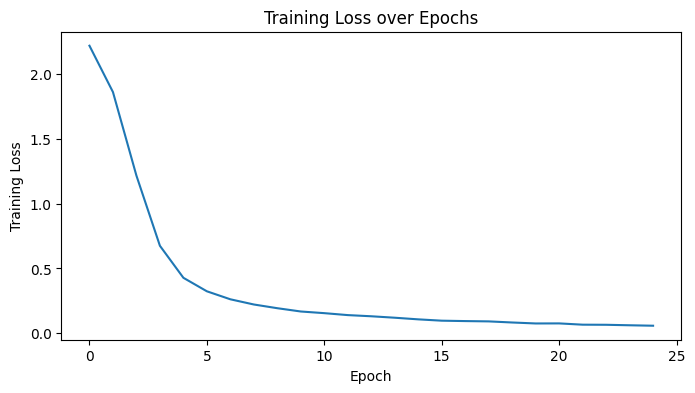

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

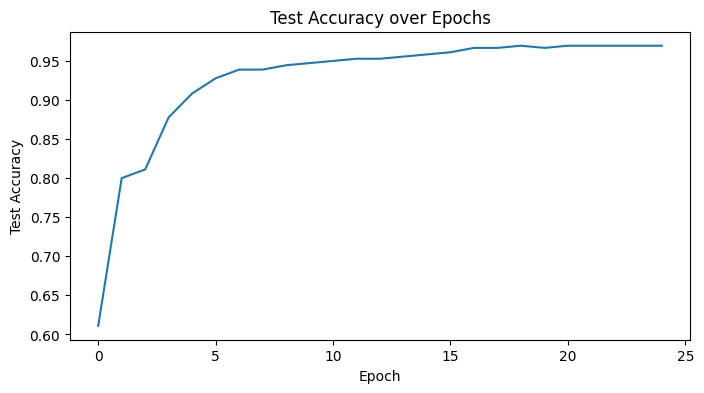

In [18]:
plt.figure(figsize=(8, 4))
plt.plot(test_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy over Epochs")
plt.show()

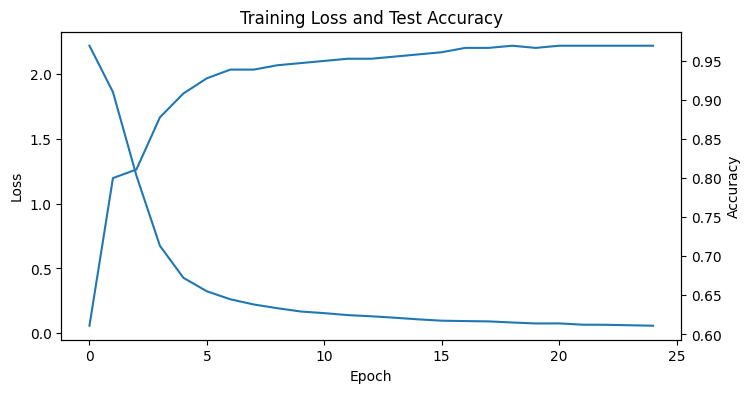

In [19]:
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot loss (left axis)
ax1.plot(train_losses, label="Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss and Test Accuracy")
ax1.tick_params(axis='y')

# Second axis for accuracy
ax2 = ax1.twinx()
ax2.plot(test_accuracies, label="Test Accuracy")
ax2.set_ylabel("Accuracy")
ax2.tick_params(axis='y')

plt.show()

## Training Conclusion

The MLP model successfully learned to classify handwritten digits from the 8×8 dataset.
Final tst accuracy = ~ 97%
Despite the low resolution of the images (8×8), the simple MLP architecture
(64 → 128 → 64 → 10) is sufficient to achieve high performance.

## Next step

The trained model will now be:

1. Transferred to a production-ready training script (`src/model/train.py`)
2. Exported to TorchScript format
3. Saved inside the `artifacts/` directory
4. Used later by the FastAPI application for inference

This completes the experimental phase and prepares the project for integration.